# Few_shot_test on CUB dataSet

In [37]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import imp
import utils
import torch.optim as optim
import numpy as np
import warnings
imp.reload(utils)
from sklearn.manifold import TSNE
import random
random.seed(50)
INPUT_DIM = 640
OUTPUT_DIM = 10
base_features_path = "./data/novel_features.plk"
warnings.filterwarnings('ignore')

In [30]:
# Reading data features
datater = utils.Data()
f_matrix,labels,means,covs = datater.read_data(base_features_path,INPUT_DIM,0,10,'cub')
f_matrix = (f_matrix-np.min(f_matrix))/np.max(f_matrix)
print(means.shape)
x_train,x_test,y_train,y_test = utils.split_dataset(f_matrix,labels,2) # 划分数据集
print(x_train.shape,x_test.shape)

600 0
1200 1
1800 2
2400 3
3000 4
3600 5
4200 6
4800 7
5400 8
6000 9
(10, 640)
(3000, 640) (3000, 640)


## Generate TestSet

[6 1 3 0 7]
(25, 640)
Logistic Acc (all):0.804


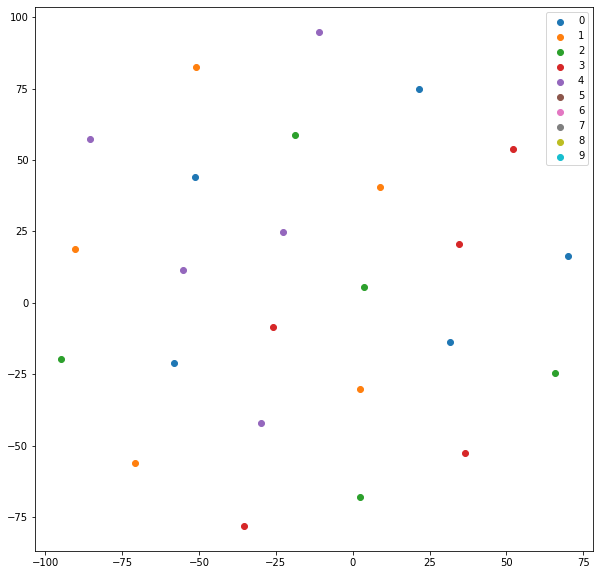

In [31]:
# visulize the features
random_index=np.random.permutation(np.arange(10))[0:5]
print(random_index)
few_x,few_y = datater.data_generator(random_index,x_train,y_train,5)
tx,ty = datater.data_generator(random_index,x_test,y_test,150)
print(few_x.shape)

tsne = TSNE()
out = tsne.fit_transform(few_x)
plt.figure(figsize=(10,10))
for i in range(10):
    indices = few_y == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()
plt.show()

In [32]:
upper = utils.Distill(10)
x_up,y_up = upper.upsampling_few(few_x,few_y,200,bias=0.00)
# print(x_up)

(1000, 640) (1000,)


In [33]:
model = utils.MCC(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
utils.train(model,optimizer,x_up,y_up,0.5)
W1 = model.fc1.weight.clone().detach().numpy()

loss at  0  is 11.42314338684082
loss at  100  is -0.02213963121175766
loss at  200  is -0.03712281957268715
loss at  300  is -0.06818562000989914
loss at  400  is -0.11301562190055847
loss at  500  is -0.13267368078231812


In [34]:
x_r_new = x_up@W1.T
x_t_new = tx@W1.T
# acc = utils.logistic_test(x_r_new,y_up,x_t_new,ty)
acc = utils.knn_test(x_r_new,y_up,x_t_new,ty)
print("The acc of PEM is:",acc)

The acc of PEM is: 0.8146666666666667


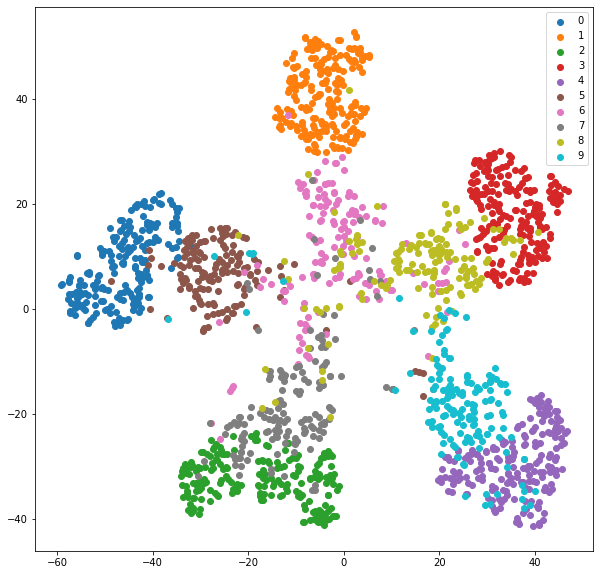

In [35]:
tsne = TSNE()
out = tsne.fit_transform(np.vstack((x_r_new,x_t_new)))
plt.figure(figsize=(10,10))
tty = ty+5
for i in range(10):
    indices = np.hstack((y_up,tty)) == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()
plt.show()

## Run Batch Test in Few-shot learning Problem

In [124]:
# Hyperparameter grid
import random
param_grid = {
    'learning_rate': list(np.linspace(0.1060, 0.1090, num = 100)),
    'output_dim': list(range(8,12,1)),
    'decay': [3e-4,5e-4,6e-4,7e-4],
    'g1':[0.4,0.5],
    'sam_num':[200,250,300]
}
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'learning_rate': 0.10657575757575757,
 'output_dim': 10,
 'decay': 0.0003,
 'g1': 0.4,
 'sam_num': 250}

In [122]:
FT = utils.FewShoot()
# One time test function
def one_test(params,test_num):
    accs = []
    for i in range(test_num):
        random_index=np.random.permutation(np.arange(10))[0:5]
        f_x,f_y = datater.data_generator(random_index,x_train,y_train, 5)
        t_x,t_y = datater.data_generator(random_index,x_test,y_test,50)
        n_acc = FT.booster_sample(f_x,f_y,t_x,t_y,params,ways=5)
        print("ACC:",n_acc)
        accs.append(n_acc)
    accs = np.array(accs)
    return np.mean(accs)

acc_total = one_test(params,1)
print("The avarange acc is",acc_total)

(1250, 640) (1250,)
loss at  0  is 4.8378496170043945
loss at  100  is -0.0021408521570265293
loss at  200  is -0.002317375037819147
loss at  300  is -0.002517181448638439
loss at  400  is -0.0027209948748350143
loss at  500  is -0.002851427998393774
The acc of PEM (logistic) is: 0.744
ACC: 0.744
The avarange acc is 0.744


In [ ]:
# random.seed(50)
# random_params = []
# random_accs = []
# for epo in range(30):
# #     params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
#     params = {'learning_rate': 0.10787878787878788, 'output_dim': 6, 'decay': 5e-05}
#     acc = one_test(params,50)
#     random_params.append(params)
#     random_accs.append(acc)
#     print("Acc:",acc,"Params:",params)
# A1 = np.array(random_accs)
# print(np.mean(A1),np.std(A1))
# idx_max = np.argmax(A1)
# print(random_params[idx_max],random_accs[idx_max])